In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import statsmodels.formula.api as smf
from scipy.stats import rankdata

from sklearn import linear_model, neighbors, ensemble
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, quantile_transform

In [2]:
''' This study investigates potential associations of screen time and outdoor play (as a 
proxy for physical activity) with social skills. Cross sectional data were available for 
575 mothers with a child (54% boys) aged 2–5 years in diverse neighborhoods throughout 
Melbourne. Mothers were found via ads on parenting and child education blogs, and were
instructed to report their child’s screen time, outdoor play time and social skills 
(ASBI system)'''
#https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0193700
#https://dro.deakin.edu.au/view/DU:30106962
df = pd.read_csv('stdataset.csv')
df.columns = ["ID", 'gender', 'age', 'disability', 'mothersEdu', 'allSocialSkills', 'express', 'comply', 
              'disrupt', 'meetStReqs', 'meetPhysReqs', 'screenTime', 'tvTime', 'cpuTime', 'outdoorTime']
df.disability = np.where(df.disability == 'Yes', 1, 0)
print(df.shape)
df.head()

(575, 15)


,ID,gender,age,disability,mothersEdu,allSocialSkills,express,comply,disrupt,meetStReqs,meetPhysReqs,screenTime,tvTime,cpuTime,outdoorTime
0,30208,Female,3.030801,0,3,78,38,24,12,0,0,3.000000,2.000000,1.0,1.500000
1,30400,Female,3.865845,0,3,82,39,27,10,1,1,0.000000,0.000000,0.0,4.000000
2,30863,Female,2.130048,0,3,68,35,18,11,1,0,0.857143,0.857143,0.0,1.714286
3,30530,Male,2.105407,0,3,63,29,20,12,1,0,0.500000,0.500000,0.0,1.500000
4,300057,Female,2.403833,0,3,78,38,25,11,1,0,0.357143,0.357143,0.0,1.500000


# Notes on the columns, where necessary:
- **disability**: self-reported
- **mothersEdu**: 1 means 10 years or less, 2 means 12 years or a equivalent of a trade school, and 3 means 14+ years or high education
- **allSocialSkills**: summary of the following 3 categories, all self-reported by the mother
- **express**: Mother rates their child's ability to express themself using thirteen subcategories on 3 point Likert scale. All her choices are summed
- **comply**: Mother rates their child's tendency to comply using ten subcategories on 3 point Likert scale. All her choices are summed
- **disrupt**: Mother rates their child's tendency to disrupt on seven subcategories on 3 point Likert scale. All her choices are summed
- **meetStReqs**: Whether or not this family meets the country's (AUS) screen time recommendations. this is a dichotomized version of the 3 screen time variables below
- **meetPhysReqs**: Whether or not this family meets the country's (AUS) physical activity recommendations. this is a dichotomized version of the outdoor play variable below
- **screenTime, tvTime, cpuTime, outdoorTime**: Average hours per day, reported by mother. Screentime is a sum of tvTime and cpuTime


# Data Exploration

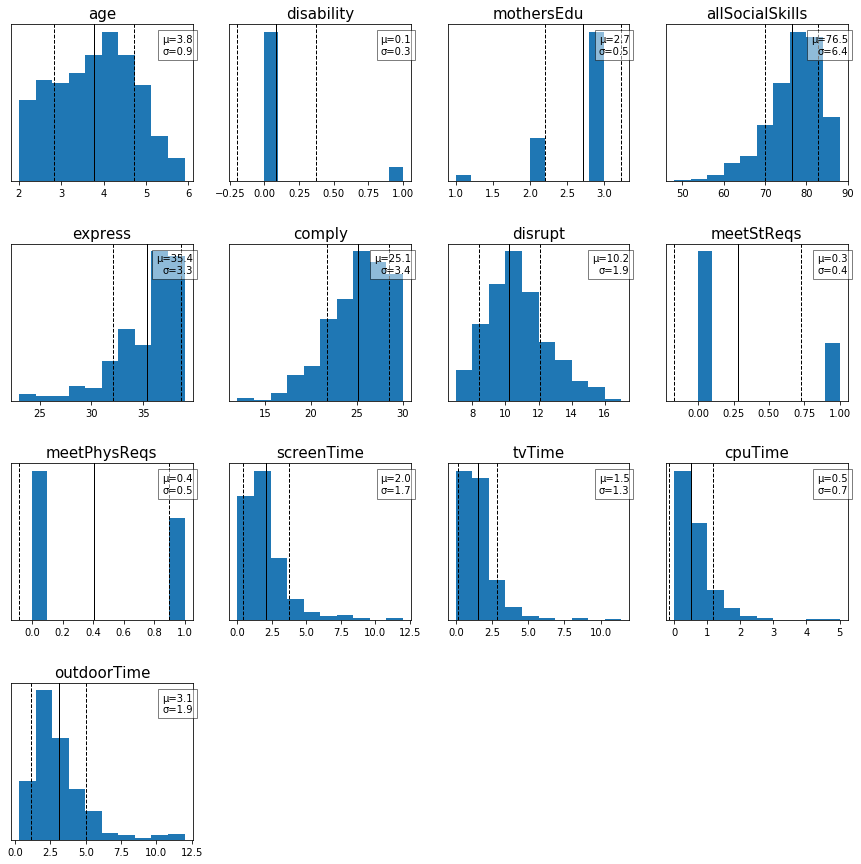

In [3]:
#Prints the distribution of all the numeric variables
f = plt.figure(figsize=[15,15])
for j,x in enumerate(df.columns[2:]):
    ax = f.add_subplot(4,4,j+1)
    plt.hist(df[x])
    plt.axvline(df[x].mean(), color='k', linestyle='solid', linewidth=1)
    plt.axvline(df[x].mean() - df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(df[x].mean() + df[x].std(), color='k', linestyle='dashed', linewidth=1)
    plt.yticks([])
    title = "μ="+str(round(df[x].mean(),1))+"\nσ="+str(round(df[x].std(),1))
    plt.text(1,.8,title,horizontalalignment='right',verticalalignment='bottom', 
             transform=ax.transAxes,bbox={'facecolor':'white', 'alpha': .5})
    plt.title(x, fontsize=15)
plt.subplots_adjust(hspace=.4)
plt.show()

Note that "allSocialSkills" is a calculated field that incorporates "express", "comply", and "disrupt". See [here](https://journals.sagepub.com/doi/10.1177/073428299201000303) for more information on the ASBI. 

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


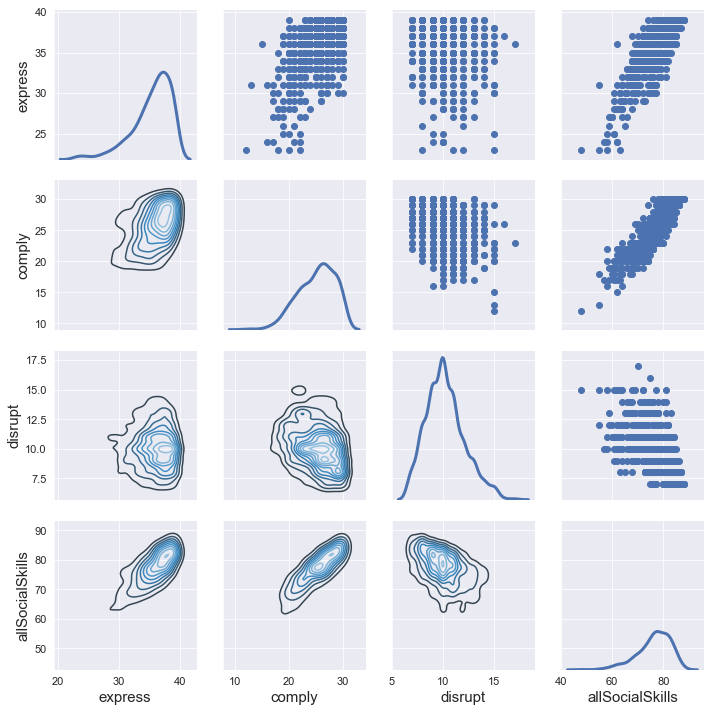

In [4]:
#Show the relationships between allSocialSkills and its 3 components
sns.set({'axes.titlesize':15., 'axes.labelsize':15., 'xtick.labelsize': 11.0,
         'ytick.labelsize': 11.0,'legend.fontsize': 11.0})
g = sns.PairGrid(df[['express', 'comply', 'disrupt', 'allSocialSkills']])
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(sns.kdeplot, lw=3, legend=False)
plt.show()

In [5]:
#Demonstrate their relationship with a linear regression model that will be nearly perfect
regr = linear_model.LinearRegression()
x = df[['express', 'comply', 'disrupt']]
y = df.allSocialSkills
regr.fit(x,y)
scores = cross_val_score(regr,x,y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))

Fold Scores:  [0.98852157 0.99074261 0.98442617 0.99619107 0.99174191 0.99552325
 0.98661701 0.99385063 0.9916524  0.99170743]

Average Score:  0.9910974050546434


# Can the Social Skills summary be predicted without using any of it's components - that is, using demographic and activity information?    

**Steps taken:**    
- OneHotEncode gender and mother's education
- lasso regression to see which features are useful
- linear regression and other regressor types with remaining variables

**One-Hot-Encoding**

In [6]:
df = pd.get_dummies(df, columns=['gender', 'mothersEdu'])
df.head()

,ID,age,disability,allSocialSkills,express,comply,disrupt,meetStReqs,meetPhysReqs,screenTime,tvTime,cpuTime,outdoorTime,gender_Female,gender_Male,mothersEdu_1,mothersEdu_2,mothersEdu_3
0,30208,3.030801,0,78,38,24,12,0,0,3.000000,2.000000,1.0,1.500000,1,0,0,0,1
1,30400,3.865845,0,82,39,27,10,1,1,0.000000,0.000000,0.0,4.000000,1,0,0,0,1
2,30863,2.130048,0,68,35,18,11,1,0,0.857143,0.857143,0.0,1.714286,1,0,0,0,1
3,30530,2.105407,0,63,29,20,12,1,0,0.500000,0.500000,0.0,1.500000,0,1,0,0,1
4,300057,2.403833,0,78,38,25,11,1,0,0.357143,0.357143,0.0,1.500000,1,0,0,0,1


**Feature Selection**

In [7]:
lass = linear_model.Lasso(alpha=.1)
x = df[['age', 'disability', 'meetStReqs', 'meetPhysReqs', 'tvTime',
       'cpuTime', 'outdoorTime', 'gender_Female', 'gender_Male',
       'mothersEdu_1', 'mothersEdu_2', 'mothersEdu_3']]
y = df.allSocialSkills
lass.fit(x,y)
print("Chosen coefficients (features with zero can be removed):")
display([(x.columns[i],lass.coef_[i]) for i in range(len(x.columns))])

Chosen coefficients (features with zero can be removed):


[('age', 1.6586579381613746),
 ('disability', -2.7994420643600773),
 ('meetStReqs', 0.0),
 ('meetPhysReqs', -0.0),
 ('tvTime', -0.5419058614570765),
 ('cpuTime', -0.283235571893437),
 ('outdoorTime', 0.43152464585135686),
 ('gender_Female', 1.2259020964535148),
 ('gender_Male', -0.0),
 ('mothersEdu_1', -0.0),
 ('mothersEdu_2', 0.0),
 ('mothersEdu_3', -0.0)]

**Linear Regression**

In [8]:
linear_formula = 'allSocialSkills ~ age+disability+tvTime+cpuTime+outdoorTime+gender_Female'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        allSocialSkills   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     14.45
Date:                Wed, 02 Jan 2019   Prob (F-statistic):           2.28e-15
Time:                        14:57:48   Log-Likelihood:                -1843.6
No. Observations:                 575   AIC:                             3701.
Df Residuals:                     568   BIC:                             3732.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        68.8026      1.137     60.524      0.000      66.570      71.035
age               1.8390      0.269      6.834      0.000       1.310       2.368
disability       -4.0338      0.899     -4.489      0.000      -5.799      -2.269
tvTime           -0.6026      0.205     -2.945      0.003      -1.005      -0.201
cpuTime          -0.5011      0.401     -1.250      0.212      -1.288       0.286
outdoorTime       0.4907      0.136      3.596      0.000       0.223       0.759
gender_Female     1.5896      0.511      3.113      0.002       0.587       2.593
==============================================================================
Omnibus:                       43.063   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.024
Skew:                          -0.683   Prob(JB):                     8.32e-12
Kurtosis:                       3.514   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The features selected by lasso regression are very intuitive: age and disability both have a strong impact on social development, girls develop social skills faster than boys, and the measured activities also are theorized to impact social development. Other Notes:
- The accuracy (adj R^2 = 12.3%) is quite poor, indicating that these are not the best predictors.
- The P-values indicate these results are probably not random except for cputTime, which is inconclusive and may just be noise. 

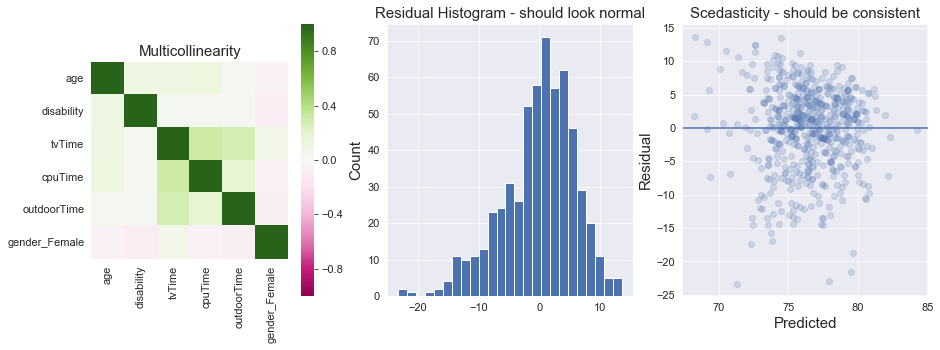

In [9]:
#Let's check how our output looks:
x = df[['age', 'disability', 'tvTime',
       'cpuTime', 'outdoorTime', 'gender_Female']]

regr.fit(x,y)
pred = cross_val_predict(regr,x,y,cv=5)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

- Lasso did a good job removing any highly correlated features.
- The Residual histogram is slightly skewed, inheriting the skew we saw in the target variable itself
- The scedasticity chart is not perfect, showing larger residuals in the long left tail of the target variable, and smaller residuals to the right.

# A Quartile transform to normalize the dependent variable improves the scedasticity and residual imbalances, but at the expense of 1% of accuracy

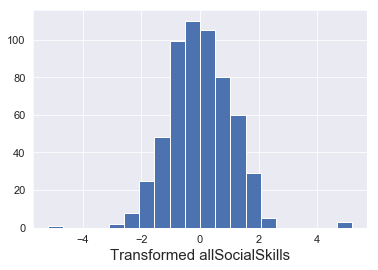

In [10]:
#Transform allSocialSkills to a normal distribution using sklearn's quantile transform
y_trans = quantile_transform(pd.DataFrame(df.allSocialSkills),output_distribution='normal').squeeze()
df['ytrans'] = y_trans
plt.hist(df.ytrans, bins=20)
plt.xlabel('Transformed allSocialSkills')
plt.show()

In [11]:
linear_formula = 'ytrans ~ age+disability+tvTime+cpuTime+outdoorTime+gender_Female'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ytrans   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     13.87
Date:                Wed, 02 Jan 2019   Prob (F-statistic):           9.59e-15
Time:                        14:57:48   Log-Likelihood:                -811.75
No. Observations:                 575   AIC:                             1638.
Df Residuals:                     568   BIC:                             1668.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.3245      0.189     -7.010      0.000      -1.696      -0.953
age               0.3180      0.045      7.110      0.000       0.230       0.406
disability       -0.5579      0.149     -3.736      0.000      -0.851      -0.265
tvTime           -0.0951      0.034     -2.796      0.005      -0.162      -0.028
cpuTime          -0.0968      0.067     -1.453      0.147      -0.228       0.034
outdoorTime       0.0882      0.023      3.888      0.000       0.044       0.133
gender_Female     0.2185      0.085      2.575      0.010       0.052       0.385
==============================================================================
Omnibus:                       59.963   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.371
Skew:                           0.445   Prob(JB):                     1.87e-44
Kurtosis:                       5.759   Cond. No.                         25.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

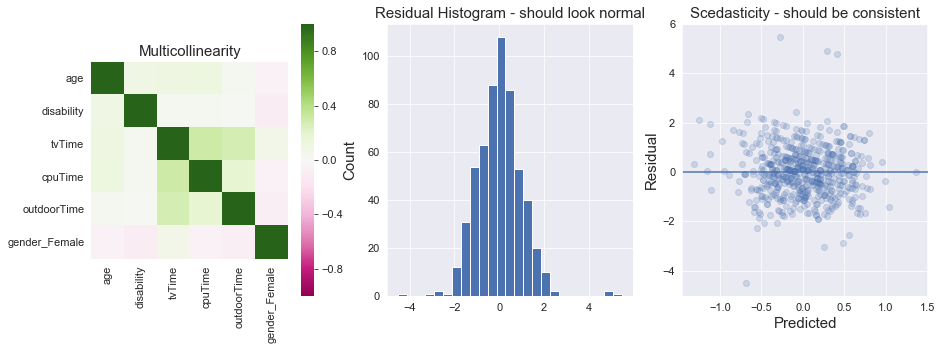

In [12]:
y = df.ytrans
regr.fit(x,y)
pred = cross_val_predict(regr,x,y,cv=5)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title('Multicollinearity')
sns.heatmap(x.corr(), vmin = -1,square=True, cmap="PiYG")
plt.subplot(132)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()


# Let's see if other Regressor Types can do better:

In [65]:
#Create test/train splits
x = df[['age', 'disability', 'tvTime', 'cpuTime', 'outdoorTime', 'gender_Female']]
y=df.allSocialSkills
trainx, testx, trainy, testy = train_test_split(x,y, test_size=.5)

In [70]:
def score_model(model, test_features, test_target):
    print('Model Performance')
    print(model.score(test_features,test_target))
    print('---')

**Random Forest Regressor gridsearch**

In [66]:
#Define the parameters we want to cycle through
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 5, 10],
    'max_features': [2, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300, 400, 500]
}

In [67]:
rfr = ensemble.RandomForestRegressor()
gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
gs.fit(trainx, trainy)

#Let's see what came out best:
gs.best_params_

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

Using the Randomized Search CV, we can find the general range of paramaters that  perform best, in this case raising R^2 scores as seen in the below comparison:

In [75]:
base_rfr = ensemble.RandomForestRegressor(n_estimators=10)
base_rfr.fit(trainx,trainy)
score_model(base_rfr,testx,testy)
best_gs = gs.best_estimator_
score_model(best_gs, testx,testy)

Model Performance
-0.25167434499736263
---
Model Performance
-0.018854379558405965
---


Despite the above returning an ideal model, test data is performing significantly worse than training data. the Cross Validation built in to the grid search may be insufficient to prevent overfitting with so few samples. To dig deeper, let's isolate the depth of the trees as seen below:

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


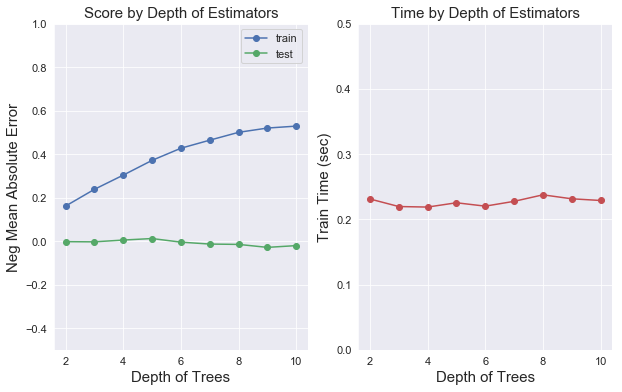

In [105]:
rfr = ensemble.RandomForestRegressor(n_estimators=100,bootstrap=True,max_features=2,
                                     min_samples_leaf=3,min_samples_split=4,)

#Limit everything except n_estimators to the best param identified in the last grid search
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10]
}
gst = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
gst.fit(trainx, trainy)


# Extract information from the cross validation model
train_scores = gst.cv_results_['mean_train_score']
test_scores = gst.cv_results_['mean_test_score']
param_values = list(gst.cv_results_['param_max_depth'])
train_time = gst.cv_results_['mean_fit_time']

# Plot the scores over the parameter
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.plot(param_values, train_scores, 'bo-', label = 'train')
plt.plot(param_values, test_scores, 'go-', label = 'test')
plt.legend()
plt.xlabel('Depth of Trees')
plt.ylabel('Neg Mean Absolute Error')
plt.title('Score by Depth of Estimators')
plt.ylim([-.5,1])

plt.subplot(122)
plt.plot(param_values, train_time, 'ro-')

plt.title('Time by Depth of Estimators')
plt.ylabel('Train Time (sec)')
plt.xlabel('Depth of Trees')
plt.ylim([0,.5])


plt.show()

**KNN Regressor**

In [109]:
#Define the parameters we want to cycle through
param_grid = {
    'n_neighbors': [2,5,10,30,50,75],
    'weights' : ['uniform', 'distance']
}

In [110]:
knnr = neighbors.KNeighborsRegressor()
knngs = GridSearchCV(estimator=knnr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
knngs.fit(trainx, trainy)

#Let's see what came out best:
knngs.best_params_

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 50, 'weights': 'distance'}

Plot the change in accuracy as we increase neighbors using distance weighting:

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


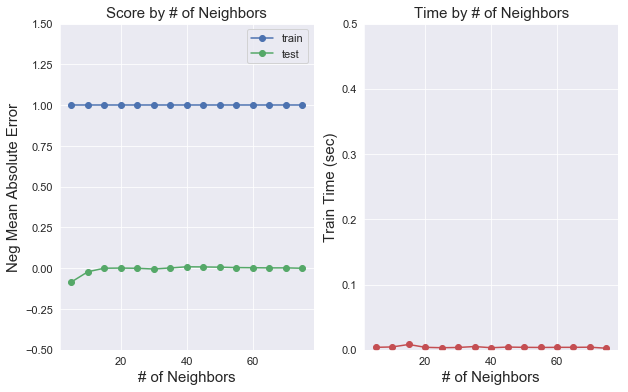

In [114]:
knnr = neighbors.KNeighborsRegressor(weights='distance')

param_grid = {
    'n_neighbors': [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
}
knngs = GridSearchCV(estimator=knnr, param_grid=param_grid,cv=5, n_jobs=-1)

#Fit the grid search to data:
knngs.fit(trainx, trainy)


# Extract information from the cross validation model
train_scores = knngs.cv_results_['mean_train_score']
test_scores = knngs.cv_results_['mean_test_score']
param_values = list(knngs.cv_results_['param_n_neighbors'])
train_time = knngs.cv_results_['mean_fit_time']

# Plot the scores over the parameter
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.plot(param_values, train_scores, 'bo-', label = 'train')
plt.plot(param_values, test_scores, 'go-', label = 'test')
plt.legend()
plt.xlabel('# of Neighbors')
plt.ylabel('Neg Mean Absolute Error')
plt.title('Score by # of Neighbors')
plt.ylim([-.5,1.5])

plt.subplot(122)
plt.plot(param_values, train_time, 'ro-')
plt.xlabel('# of Neighbors')
plt.title('Time by # of Neighbors')
plt.ylabel('Train Time (sec)')
plt.ylim([0,.5])


plt.show()

Perfect scoring on training data is to be expected when distance weighting is used, as each point will be weighted 1 to score itself. Regardless, once you get to ~20 neighbors, adding more seems to make no difference on test data accuracy. KNN is not an improvement on Random Forest or Linear Regression.